**Creating Spatial Adjacency Matrix for each Suburb**

In [2]:
import pandas as pd
import geopandas as gpd

In [3]:
suburbs_gdf = gpd.read_file("../data/geo/shpfile/LOCALITY_POLYGON.shp")
suburbs_gdf["LOCALITY"] = suburbs_gdf["LOCALITY"].apply(lambda x: x.lower())

In [4]:
import geopandas as gpd
import numpy as np
from scipy.spatial import cKDTree
k = 15

# 1) Load suburbs and project to a metric CRS (meters)
if suburbs_gdf.crs is None or suburbs_gdf.crs.is_geographic:
    suburbs_gdf = suburbs_gdf.to_crs(3111)  # VIC metric; adjust if needed

# 2) Use centroids for nearest-neighbor search
centroids = suburbs_gdf.geometry.centroid
coords = np.column_stack([centroids.x, centroids.y])

# 3) KDTree: get the nearest other suburb (k=2; skip self at [:,1])
tree = cKDTree(coords)
dists, idxs = tree.query(coords, k=16)
nearest_idx = idxs[:, 1:]        # nearest other suburb index
nearest_dist_m = dists[:, 1:]    # distance in meters to nearest other suburb

# 4) Build a nearest-suburb mapping (use your name/id column)
name_col = "LOCALITY"  # change to your actual column
suburb_names = suburbs_gdf[name_col].tolist()
nearest_suburbs_by_name = {
    suburb_names[i]: list(
        zip(
            [suburb_names[j] for j in idx_row],    # neighbor names
            dist_row                               # matching distances
        )
    )
    for i, (idx_row, dist_row) in enumerate(zip(nearest_idx, nearest_dist_m))
}


# build column names
cols = [f"neighbor_{i+1}" for i in range(k)]

df_neighbors = (
    pd.DataFrame.from_dict(nearest_suburbs_by_name, orient="index")
    .iloc[:, :k]  # just in case some lists are longer
    .set_axis(cols, axis=1)
    .rename_axis("suburb")
    .reset_index()
)

df_neighbors.head()

,suburb,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_6,neighbor_7,neighbor_8,neighbor_9,neighbor_10,neighbor_11,neighbor_12,neighbor_13,neighbor_14,neighbor_15
0,mollongghip,"(rocklyn, 3581.6783617685)","(barkstead, 5112.977817535254)","(dean, 5655.445908354546)","(claretown, 5791.793172209908)","(bullarook, 5912.662413637704)","(springbank, 6072.383619194271)","(langdons hill, 6388.847032572299)","(clarkes hill, 6643.6549441883235)","(bolwarrah, 7489.006033563029)","(newlyn, 7886.515964139041)","(mount prospect, 8219.013267713259)","(korweinguboora, 8731.9131132203)","(wattle flat, 8734.950522299296)","(newlyn north, 8765.667946975016)","(spargo creek, 9239.486926869471)"
1,north blackwood,"(trentham east, 3494.2423289512035)","(trentham, 4989.125030380734)","(barrys reef, 6228.475895469958)","(fern hill, 6806.431415276523)","(newbury, 6881.401736031668)","(tylden south, 7154.459369978257)","(ashbourne, 8522.375602496413)","(little hampton, 8932.379833732171)","(lyonville, 9074.143229273675)","(lerderderg, 9941.858460551719)","(blackwood, 10085.272241416606)","(tylden, 10768.199468604995)","(bullarto south, 12482.890362035196)","(spring hill, 12789.533890891715)","(dales creek, 12922.011163263376)"
2,basalt,"(hepburn, 2188.906580747685)","(elevated plains, 3060.2551791008445)","(shepherds flat, 3662.815869185455)","(hepburn springs, 3736.1011565495974)","(dry diggings, 5152.962321160329)","(kooroocheang, 5295.357491802315)","(daylesford, 5817.341258233797)","(eganstown, 5880.769195186071)","(sailors hill, 6096.069296372985)","(mount franklin, 7006.603577538165)","(franklinford, 7373.320455164579)","(blampied, 8404.467397917868)","(porcupine ridge, 8660.809032323043)","(coomoora, 8722.267841494275)","(musk vale, 9149.091755048958)"
3,llanelly,"(tarnagulla, 5751.849152227316)","(arnold, 6142.7344175566095)","(arnold west, 7457.34599858082)","(murphys creek, 7475.316184639746)","(newbridge, 8146.6739503373665)","(waanyarra, 10536.951037668783)","(painswick, 12065.282385591465)","(kingower, 13395.740102890133)","(laanecoorie, 13671.29012631701)","(rheola, 13997.068044690785)","(mcintyre, 14256.85300922368)","(inglewood, 14398.710265505391)","(bridgewater, 15024.845144296669)","(moliagul, 15053.858236001312)","(inkerman, 15553.202620733322)"
4,murrabit west,"(gonn crossing, 4074.037812045385)","(benjeroop, 5425.375650080507)","(murrabit, 6310.258535531165)","(lake charm, 11055.729695651811)","(capels crossing, 11402.874191071445)","(winlaton, 12268.994725887009)","(mystic park, 14947.727208468184)","(fish point, 15244.896419805458)","(myall (kerang), 16000.77378441685)","(westby, 16354.057931687896)","(reedy lake, 17083.67138470873)","(tresco, 17500.867678674254)","(fairley, 20237.632476877185)","(pental island, 21030.273344240264)","(lake boga, 22597.598363624402)"


In [5]:
# Create a DataFrame to hold the adjacency matrix for each suburb
suburbs_list = list(suburbs_gdf["LOCALITY"].values)
connection_strength = 1
eps = 0.0001
matrix = pd.DataFrame(
        0.0, index=suburbs_list, columns=suburbs_list
    )

for suburb, neighbours in nearest_suburbs_by_name.items():
    for name, distance in neighbours:
        if suburb == name or distance == 0:
            continue  # skip self matches
        matrix.loc[suburb, name] = connection_strength / ((distance/1000) + eps)
        matrix.loc[name, suburb] = connection_strength / ((distance/1000) + eps)


matrix.head()


,mollongghip,north blackwood,basalt,llanelly,murrabit west,springfield (sea lake),waitchie,straten,gowanford,kunat,...,port melbourne,exford,thomastown,watsonia,bacchus marsh,christmas hills,yarra glen,heidelberg west,reservoir,parwan
mollongghip,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
north blackwood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
basalt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
llanelly,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
murrabit west,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
ts_suburbs_df = pd.read_csv("../data/curated/rent_growth/panel_data_updates.csv")
merged_dict_list = [{c : c.split("-")} for c in (set(ts_suburbs_df["suburb"]) - set((suburbs_gdf["LOCALITY"].apply(lambda x: x.lower()))))]
merged_dict_list

[{'wanagaratta': ['wanagaratta']},
 {'sale-maffra': ['sale', 'maffra']},
 {'east brunswick': ['east brunswick']},
 {'hampton-beaumaris': ['hampton', 'beaumaris']},
 {'bundoora-greensborough-hurstbridge': ['bundoora',
   'greensborough',
   'hurstbridge']},
 {'richmond-burnley': ['richmond', 'burnley']},
 {'herne hill-geelong west': ['herne hill', 'geelong west']},
 {'albert park-middle park-west st kilda': ['albert park',
   'middle park',
   'west st kilda']},
 {'werribee-hoppers crossing': ['werribee', 'hoppers crossing']},
 {'coburg-pascoe vale south': ['coburg', 'pascoe vale south']},
 {'camberwell-glen iris': ['camberwell', 'glen iris']},
 {'moe-newborough': ['moe', 'newborough']},
 {'collingwood-abbotsford': ['collingwood', 'abbotsford']},
 {'mount clear-buninyong': ['mount clear', 'buninyong']},
 {'mt eliza-mornington-mt martha': ['mt eliza', 'mornington', 'mt martha']},
 {'canterbury-surrey hills-mont albert': ['canterbury',
   'surrey hills',
   'mont albert']},
 {'glen waverl

In [7]:
overlap = set(ts_suburbs_df["suburb"]) & set((suburbs_gdf["LOCALITY"].apply(lambda x: x.lower())))

In [8]:
unmerged_suburbs = []
for combined_dict in merged_dict_list:
    for val_list in combined_dict.values():
        for vals in val_list:
            unmerged_suburbs.append(vals)

unmerged_suburbs

['wanagaratta',
 'sale',
 'maffra',
 'east brunswick',
 'hampton',
 'beaumaris',
 'bundoora',
 'greensborough',
 'hurstbridge',
 'richmond',
 'burnley',
 'herne hill',
 'geelong west',
 'albert park',
 'middle park',
 'west st kilda',
 'werribee',
 'hoppers crossing',
 'coburg',
 'pascoe vale south',
 'camberwell',
 'glen iris',
 'moe',
 'newborough',
 'collingwood',
 'abbotsford',
 'mount clear',
 'buninyong',
 'mt eliza',
 'mornington',
 'mt martha',
 'canterbury',
 'surrey hills',
 'mont albert',
 'glen waverley',
 'mulgrave',
 'doncaster east',
 'donvale',
 'prahran',
 'windsor',
 'broadmeadows',
 'roxburgh park',
 'keilor east',
 'avondale heights',
 'newtown',
 'oak park',
 'glenroy',
 'fawkner',
 'ivanhoe',
 'ivanhoe east',
 'dromana',
 'portsea',
 'dandenong north',
 'endeavour hills',
 'east st kilda',
 'mentone',
 'parkdale',
 'mordialloc',
 'hastings',
 'flinders',
 'aspendale',
 'chelsea',
 'carrum',
 'chadstone',
 'oakleigh',
 'west brunswick',
 'fairfield',
 'alphington',

In [9]:
set(unmerged_suburbs) - set((suburbs_gdf["LOCALITY"].apply(lambda x: x.lower())))

{'bendigo east',
 'east brunswick',
 'east hawthorn',
 'east st kilda',
 'mt eliza',
 'mt martha',
 'newcombe',
 'newtown',
 'wanagaratta',
 'west brunswick',
 'west st kilda'}

In [10]:
W = matrix.copy()
W

,mollongghip,north blackwood,basalt,llanelly,murrabit west,springfield (sea lake),waitchie,straten,gowanford,kunat,...,port melbourne,exford,thomastown,watsonia,bacchus marsh,christmas hills,yarra glen,heidelberg west,reservoir,parwan
mollongghip,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
north blackwood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
basalt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
llanelly,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
murrabit west,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
christmas hills,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.164665,0.000000,0.000000,0.0
yarra glen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.164665,0.000000,0.000000,0.000000,0.0
heidelberg west,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.147116,0.213793,0.000000,0.000000,0.000000,0.000000,0.230458,0.0
reservoir,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.318925,0.000000,0.000000,0.000000,0.000000,0.230458,0.000000,0.0


In [11]:
mapping = {k: list(v) for d in merged_dict_list for k, v in d.items()}
mapped_raw = {sub for parts in mapping.values() for sub in parts}

for suburb in overlap - mapped_raw:
    mapping[suburb] = [suburb]

W_new = pd.DataFrame(0.0, index=list(mapping.keys()), columns=list(mapping.keys()))

for combo_i, parts_i in mapping.items():
    for combo_j, parts_j in mapping.items():
        try:
            submatrix = W.loc[parts_i, parts_j]
            if not submatrix.empty:
                W_new.loc[combo_i, combo_j] = submatrix.values.sum()
            else:
                W_new.loc[combo_i, combo_j] = 0
        except KeyError:
            # One or more suburbs missing in original W
            W_new.loc[combo_i, combo_j] = 0


In [12]:
W_new

,wanagaratta,sale-maffra,east brunswick,hampton-beaumaris,bundoora-greensborough-hurstbridge,richmond-burnley,herne hill-geelong west,albert park-middle park-west st kilda,werribee-hoppers crossing,coburg-pascoe vale south,...,warragul,reservoir,caulfield,portland,melton,elsternwick,benalla,sydenham,malvern,craigieburn
wanagaratta,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sale-maffra,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
east brunswick,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hampton-beaumaris,0.0,0.0,0.0,0.357923,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bundoora-greensborough-hurstbridge,0.0,0.0,0.0,0.000000,0.477488,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.204853,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
elsternwick,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.584223,0.0,0.0,0.0,0.0,0.0,0.0,0.0
benalla,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sydenham,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
malvern,0.0,0.0,0.0,0.000000,0.000000,0.294647,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.320650,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Spatial Connectivity Matrix (W_new):
Values represent spatial influence weights (row-normalized)
                                    wanagaratta  sale-maffra  east brunswick  \
wanagaratta                                 0.0          0.0             0.0   
sale-maffra                                 0.0          0.0             0.0   
east brunswick                              0.0          0.0             0.0   
hampton-beaumaris                           0.0          0.0             0.0   
bundoora-greensborough-hurstbridge          0.0          0.0             0.0   
...                                         ...          ...             ...   
elsternwick                                 0.0          0.0             0.0   
benalla                                     0.0          0.0             0.0   
sydenham                                    0.0          0.0             0.0   
malvern                                     0.0          0.0             0.0   
craigieburn            

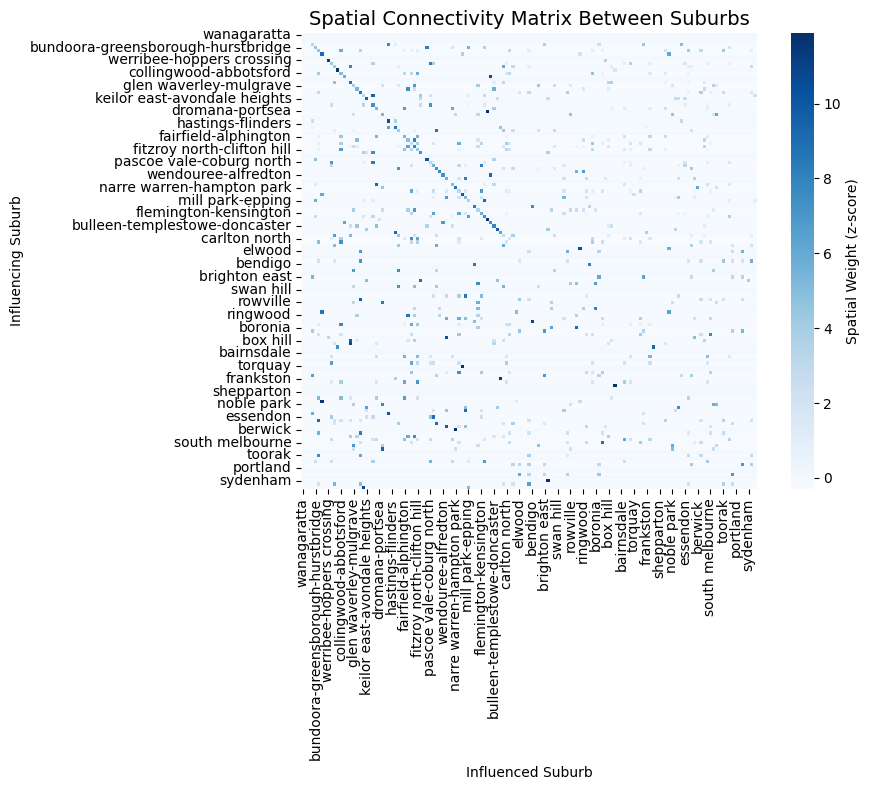

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Spatial Connectivity Matrix (W_new):")
print("Values represent spatial influence weights (row-normalized)")
print(W_new.round(3))


W_scaled = W_new.apply(
    lambda row: (row - row.mean()) / row.std() if row.std() else row,
    axis=1
)

# Visualize the spatial connectivity W_new
plt.figure(figsize=(10, 8))
sns.heatmap(
    W_scaled,
    cmap="Blues",
    fmt=".3f",
    square=True,
    cbar_kws={"label": "Spatial Weight (z-score)"}
)
plt.title('Spatial Connectivity Matrix Between Suburbs', fontsize=14)
plt.xlabel('Influenced Suburb')
plt.ylabel('Influencing Suburb')
plt.tight_layout()
plt.show()

In [15]:
# Write the adjacency matrix out as a csv
"# Persist curated spatial connectivity matrix for downstream use\n"
from pathlib import Path
output_dir = Path('../data/curated/rent_growth')
output_dir.mkdir(parents=True, exist_ok=True)
output_path = output_dir / 'spatial_connectivity_matrix.csv'
W_new.to_csv(output_path, index=True)
print(f'Saved curated spatial weight matrix to {output_path}')

Saved curated spatial weight matrix to ../data/curated/rent_growth/spatial_connectivity_matrix.csv


In [18]:
mask = W_new > 0
positives = W_new.where(mask).stack()
print(positives)

hampton-beaumaris  hampton-beaumaris              0.357923
                   mentone-parkdale-mordialloc    0.818445
                   aspendale-chelsea-carrum       0.140744
                   brighton east                  0.421860
                   brighton                       0.287343
                                                    ...   
malvern            hawthorn                       0.280644
                   toorak                         0.436677
                   caulfield                      0.320650
craigieburn        broadmeadows-roxburgh park     0.227326
                   mill park-epping               0.107325
Length: 773, dtype: float64


In [19]:
# Write the adjacency matrix out as a csv
"# Persist curated spatial connectivity matrix for downstream use\n"
from pathlib import Path
output_dir = Path('../data/curated/rent_growth')
output_dir.mkdir(parents=True, exist_ok=True)
output_path = output_dir / 'spatial_connectivity_matrix_standardized.csv'
W_scaled.to_csv(output_path, index=True)
print(f'Saved curated spatial weight matrix to {output_path}')

Saved curated spatial weight matrix to ../data/curated/rent_growth/spatial_connectivity_matrix_standardized.csv


In [20]:
row_sums = W_new.sum(axis=1)
print(row_sums.head())            # quick peek
print(row_sums.min(), row_sums.max())

# verify all rows ≈ 1
all_close = row_sums.round(6).eq(1).all()       # or:
# all_close = np.allclose(row_sums, 1.0)
print("All rows sum to 1:", all_close)

wanagaratta                           0.000000
sale-maffra                           0.000000
east brunswick                        0.000000
hampton-beaumaris                     3.045606
bundoora-greensborough-hurstbridge    2.682268
dtype: float64
0.0 13.406483339938232
All rows sum to 1: False


**Row Stochastic(each row represents a prob distribution and sums to 1 (for SAR Model)**

In [26]:
row_totals = W_new.sum(axis=1)
W_new_norm = W_new.div(row_totals.replace(0, np.nan), axis=0).fillna(0)


In [ ]:
norm_sums = W_new_norm.sum(axis=1)
print(norm_sums.head())
print("All normalized rows sum to 1:",
    np.allclose(norm_sums[row_totals > 0], 1.0))

wanagaratta                           0.0
sale-maffra                           0.0
east brunswick                        0.0
hampton-beaumaris                     1.0
bundoora-greensborough-hurstbridge    1.0
dtype: float64
All normalized rows sum to 1: True


In [22]:
# Write the adjacency matrix out as a csv
"# Persist curated spatial connectivity matrix for downstream use\n"
from pathlib import Path
output_dir = Path('../data/curated/rent_growth')
output_dir.mkdir(parents=True, exist_ok=True)
output_path = output_dir / 'spatial_connectivity_matrix_row_stochastic.csv'
W_new_norm.to_csv(output_path, index=True)
print(f'Saved curated spatial weight matrix to {output_path}')

Saved curated spatial weight matrix to ../data/curated/rent_growth/spatial_connectivity_matrix_row_stochastic.csv


**Non Scaled Version**

/opt/anaconda3/envs/pyspark-env/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/pyspark-env/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


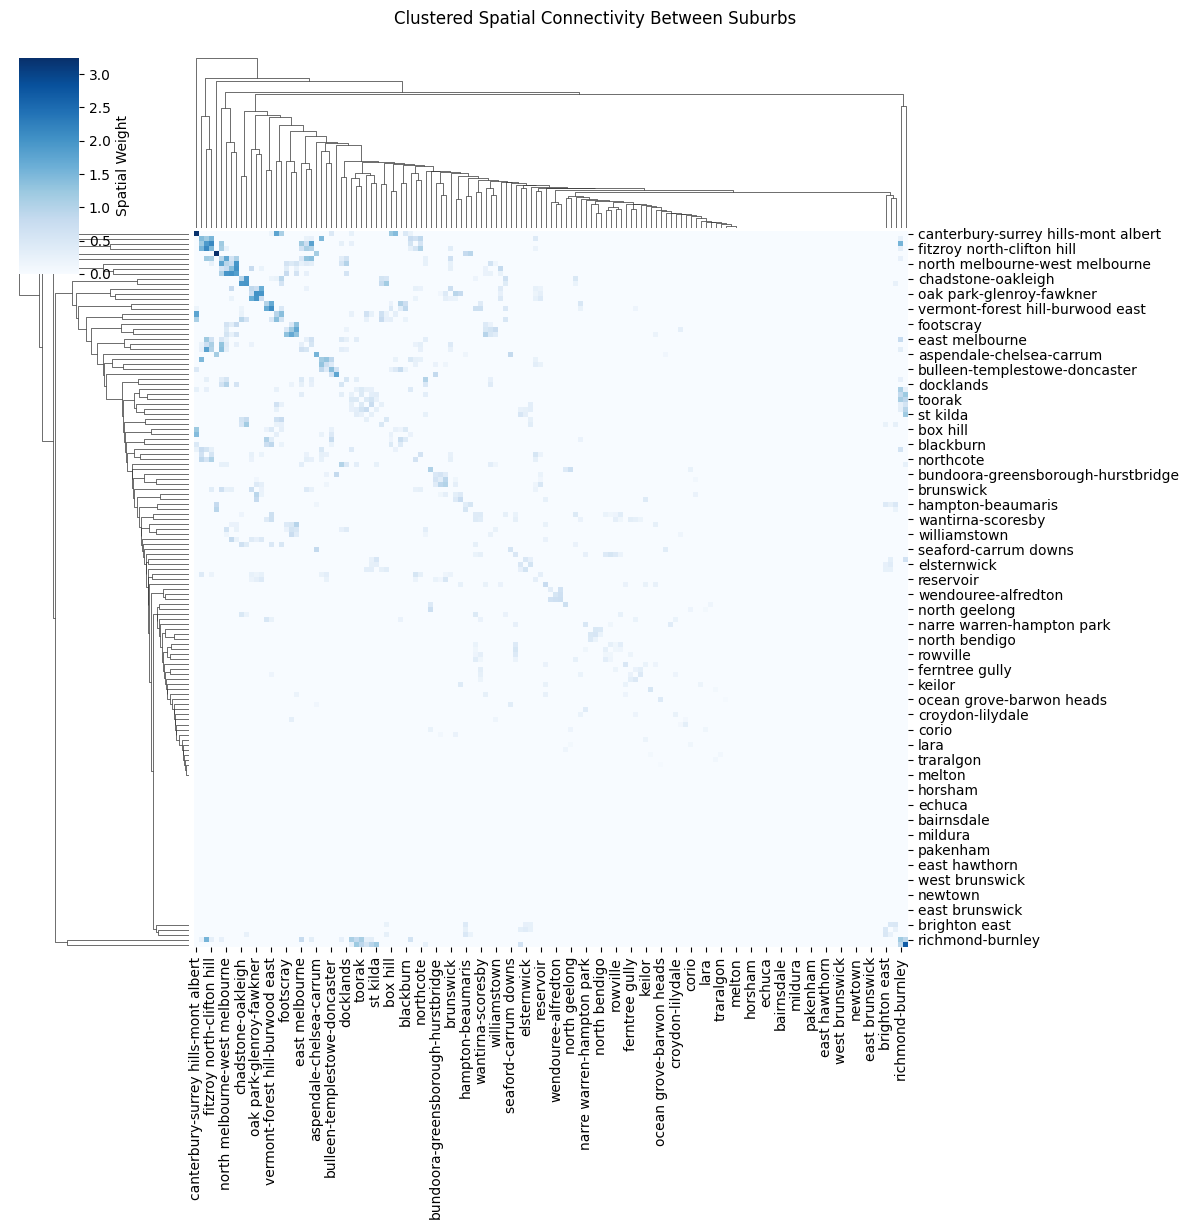

In [16]:
cluster_grid = sns.clustermap(
    W_new,
    cmap="Blues",
    metric="euclidean",
    method="average",
    figsize=(12, 12),
    cbar_kws={"label": "Spatial Weight"}
)
cluster_grid.fig.suptitle("Clustered Spatial Connectivity Between Suburbs", y=1.02)
plt.show()

**Scaled Version**

/opt/anaconda3/envs/pyspark-env/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/pyspark-env/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


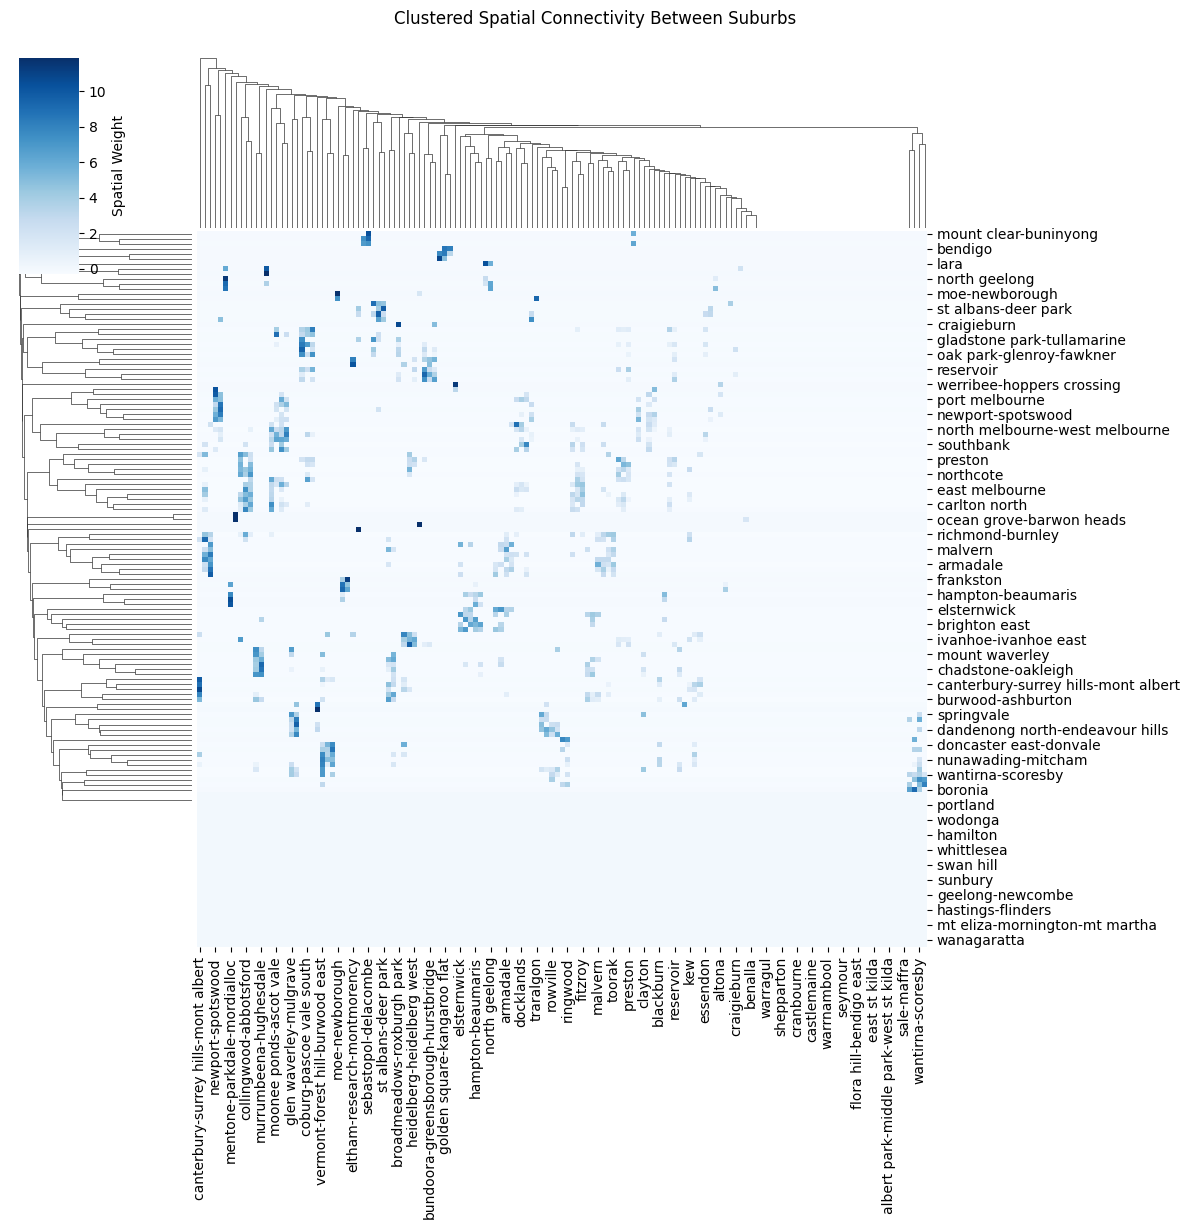

In [17]:
cluster_grid = sns.clustermap(
    W_scaled,
    cmap="Blues",
    metric="euclidean",
    method="average",
    figsize=(12, 12),
    cbar_kws={"label": "Spatial Weight"}
)
cluster_grid.fig.suptitle("Clustered Spatial Connectivity Between Suburbs", y=1.02)
plt.show()